In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

| Architecture | Mean Accuracy | Standard Deviation |
| ------------ | ------------: | -----------------: |
| ppc64el | 1.000 | 0.000 |
| armel | 1.000 | 0.000 |
| powerpc | 0.999 | 0.001 |
| alpha | 0.996 | 0.003 |
| mips64el | 0.995 | 0.004 |
| sparc | 0.994 | 0.012 |
| x32 | 0.991 | 0.003 |
| powerpcspe | 0.988 | 0.007 |
| amd64 | 0.979 | 0.016 |
| i386 | 0.970 | 0.021 |
| sparc64 | 0.949 | 0.032 |
| armhf | 0.946 | 0.023 |
| mipsel | 0.866 | 0.079 |
| ppc64 | 0.861 | 0.128 |
| arm64 | 0.777 | 0.251 |
| ia64 | 0.604 | 0.488 |
| s390x | 0.532 | 0.331 |
| hppa | 0.491 | 0.312 |
| riscv64 | 0.426 | 0.165 |
| sh4 | 0.243 | 0.281 |
| mips | 0.178 | 0.189 |
| m68k | 0.174 | 0.315 |
| s390 | 0.010 | 0.030 |
| **Overall** | **0.717** | **0.055** |

| Architecture | Mean Accuracy | Standard Deviation |
| ------------ | ------------: | -----------------: |
| s390x | 1.000 | 0.000 |
| ppc64el | 1.000 | 0.000 |
| powerpc | 1.000 | 0.000 |
| powerpcspe | 1.000 | 0.000 |
| sparc | 0.999 | 0.001 |

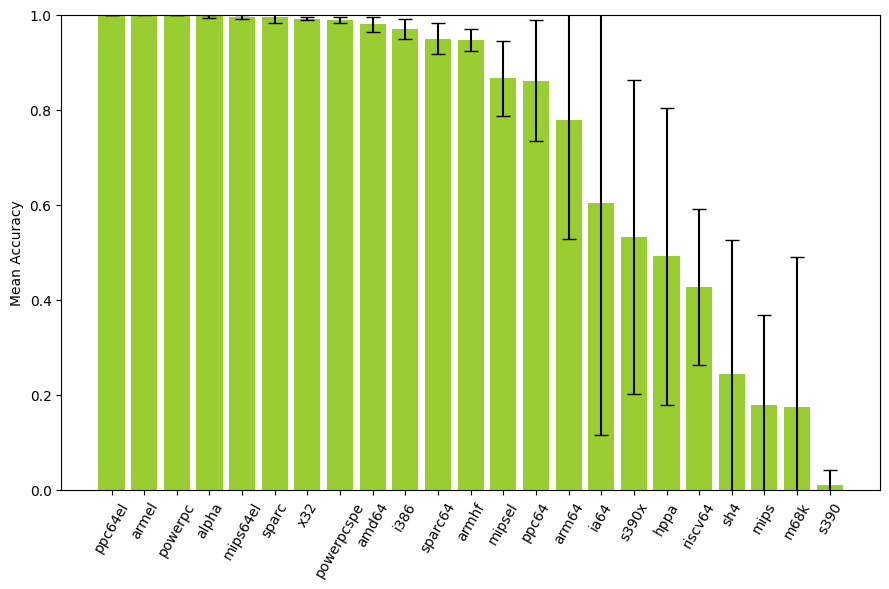

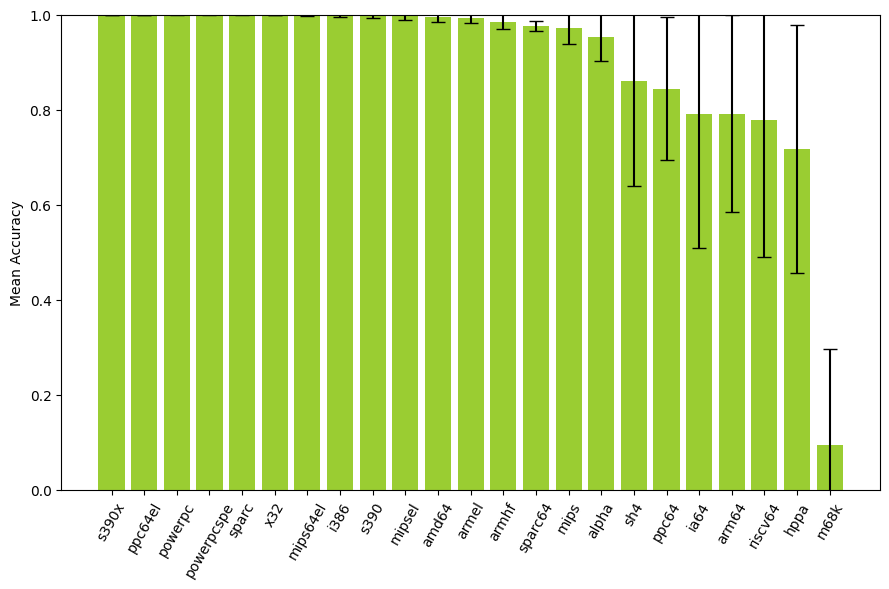

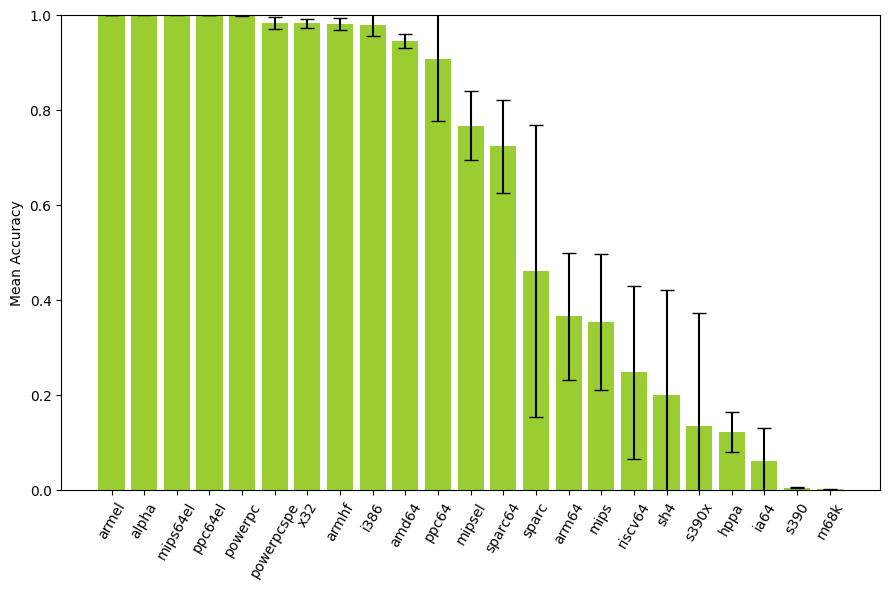

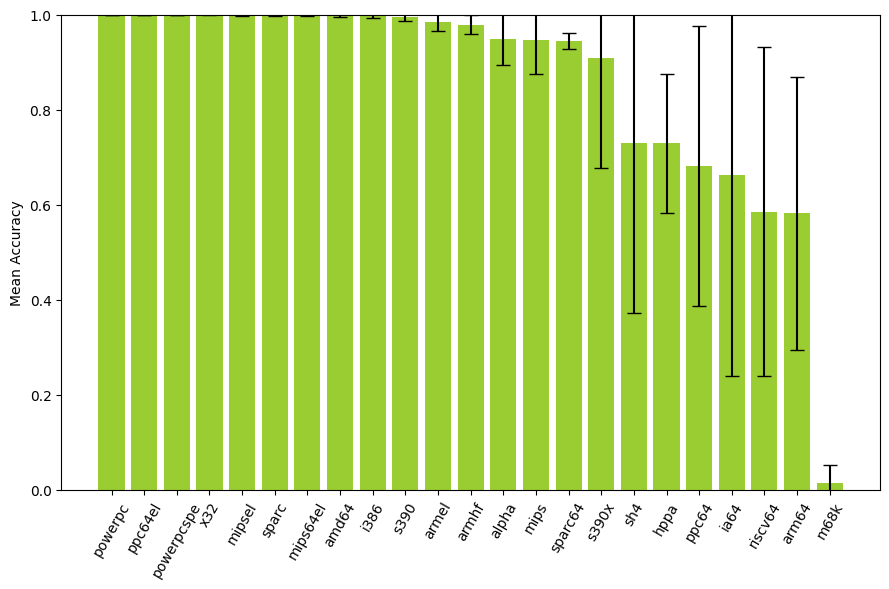

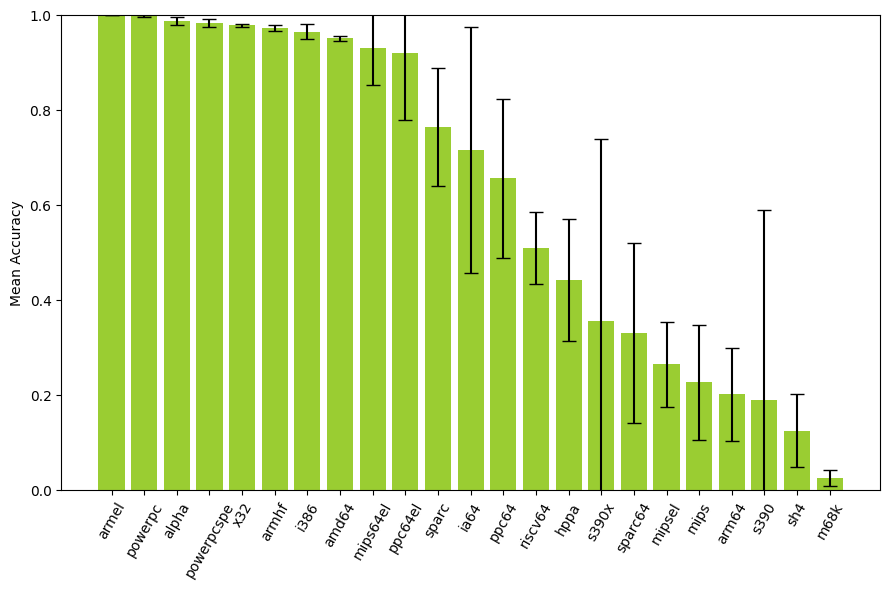

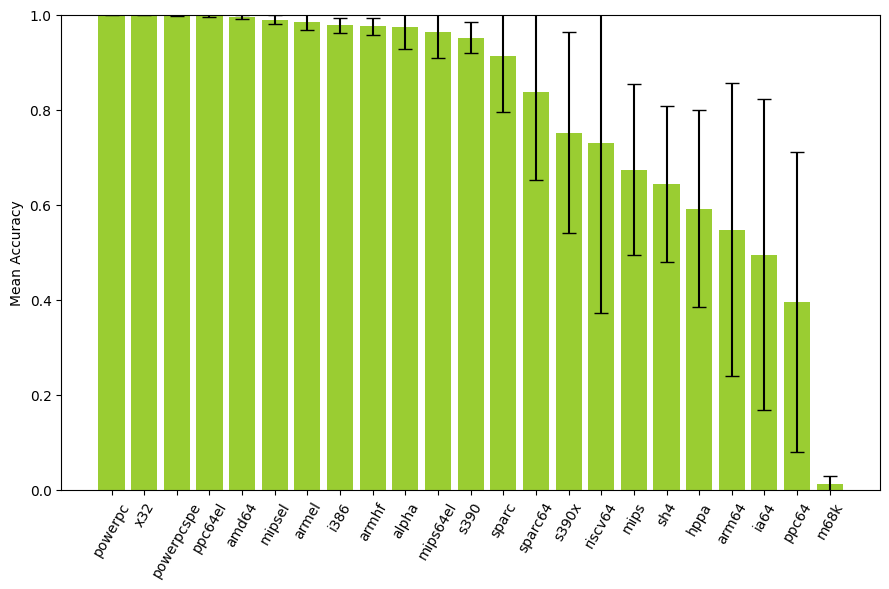

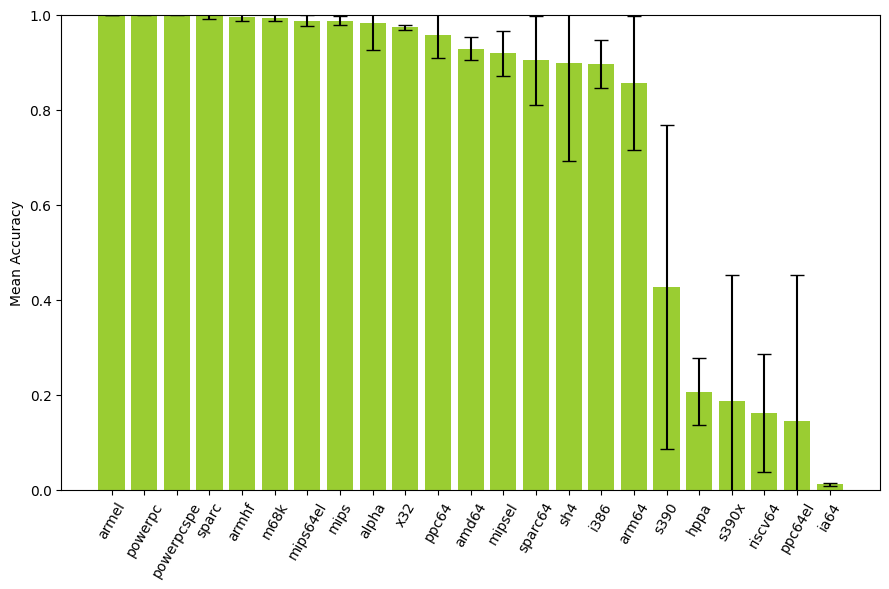

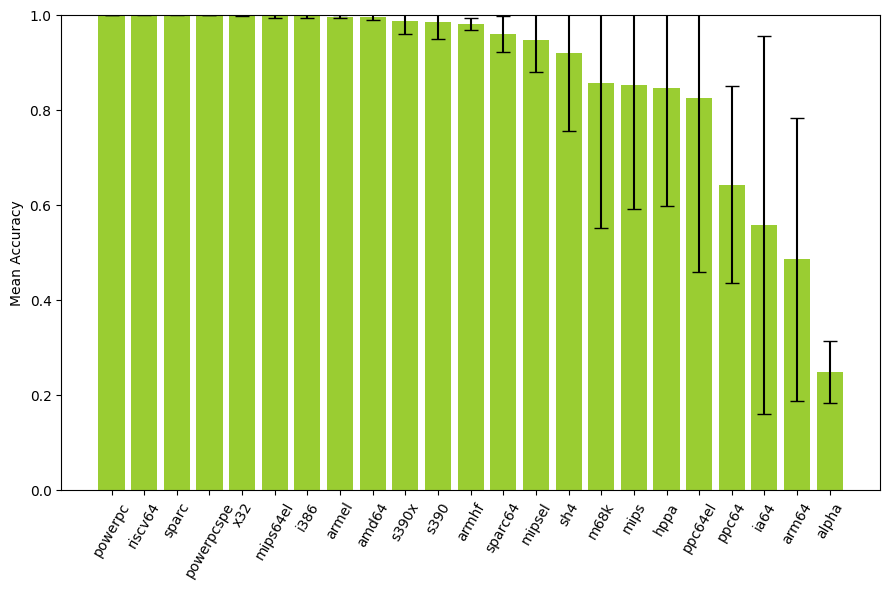

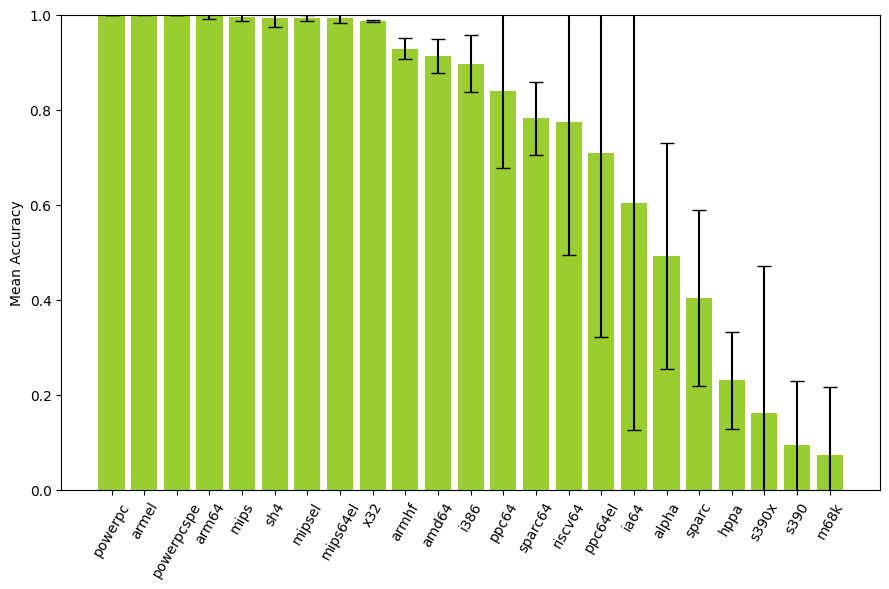

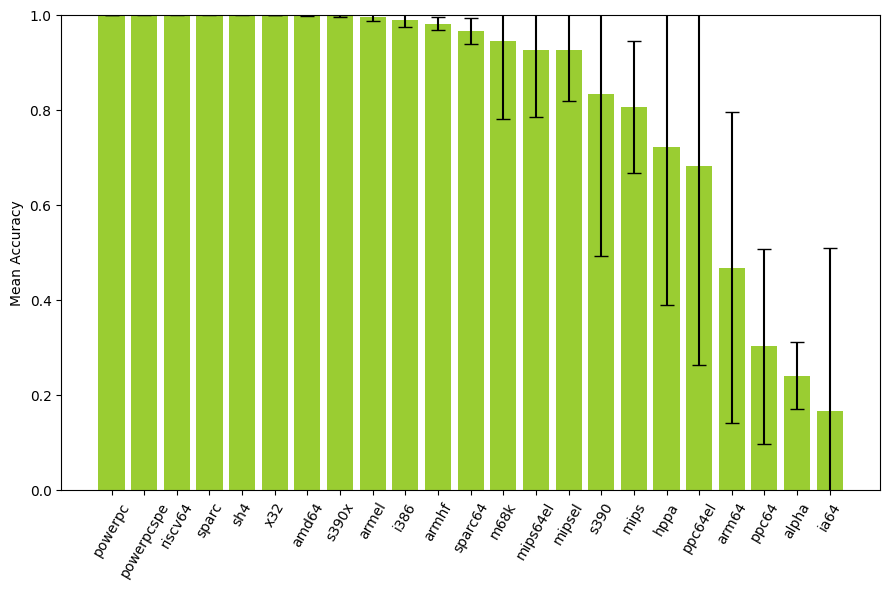

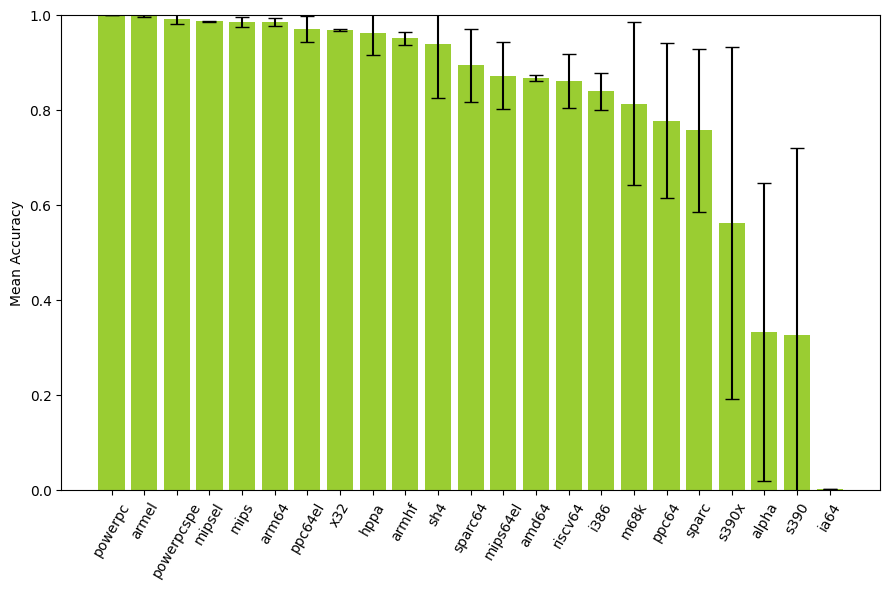

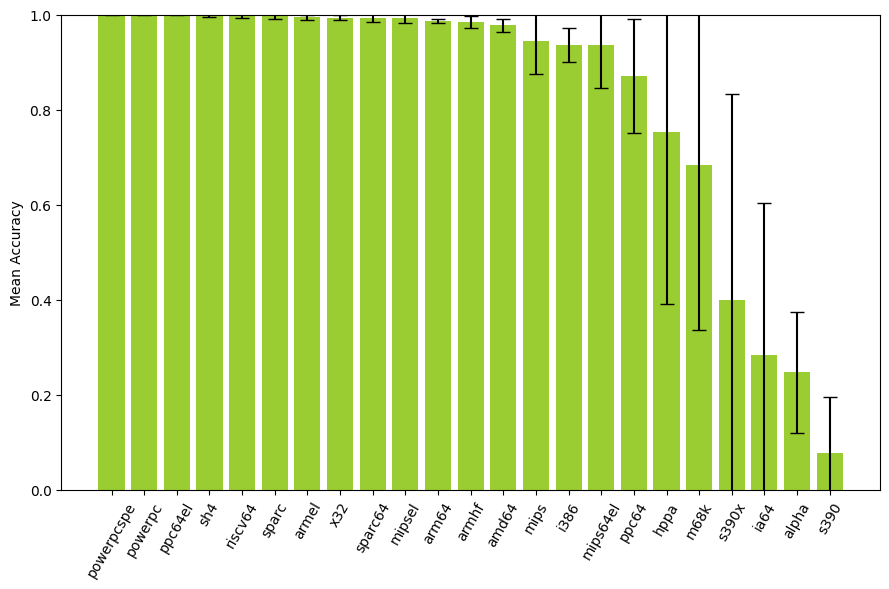

In [ ]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Compute mean and std of overall accuracy
        df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
        overall_mean = df_overall["overall_accuracy"].mean()
        overall_std = df_overall["overall_accuracy"].std()

        # Remove unnecessary columns
        df_filtered = df[["Name", "test_accuracy_file", "test_loss", "train_loss"]]

        # Remove aggregation rows and rename columns
        df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
            columns={"Name": "architecture"}
        )

        df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

        df_agg = (
            df_folds.groupby("architecture")
            .agg({"test_accuracy_file": ["mean", "std"]})
            .sort_values(("test_accuracy_file", "mean"), ascending=False)
            .reset_index()
        )
        means = df_agg[("test_accuracy_file", "mean")].values
        stds = df_agg[("test_accuracy_file", "std")].values
        architectures = df_agg["architecture"].values

        filename = f"output/logo-{target_feature.replace('_', '').lower()}-{model_name.replace('_', '').lower()}-results"

        table_string = "| Architecture | Mean Accuracy | Standard Deviation |\n"
        table_string += "| ------------ | ------------: | -----------------: |\n"

        for arch, mean, std in zip(architectures, means, stds):
            table_string += f"| {arch} | {mean:.3f} | {std:.3f} |\n"

        table_string += (
            f"| **Overall** | **{overall_mean:.3f}** | **{overall_std:.3f}** |\n"
        )

        with open(f"{filename}.md", "w") as f:
            f.write(table_string)

        print(table_string)

        plt.figure(figsize=(9, 6))
        bars = plt.bar(
            range(len(architectures)), means, yerr=stds, capsize=5, color="yellowgreen"
        )

        plt.xticks(range(len(architectures)), architectures, rotation=60)
        # plt.title(f"Overall accuracy: {overall_mean:.3f} ± {overall_std:.3f}")
        plt.ylabel("Mean Accuracy")
        plt.ylim(0, 1)

        plt.tight_layout()

        # Save the chart to an image
        filename = f"{filename}.png"
        plt.savefig(filename)